# Analyzing Breast Cancer Diagnosis with ZKP-Enabled Neural Networks

In this example, we train a simple neural network in pytorch for classification and convert it into zk circuit with ezkl for provable inference. Finally, we verify the proof onchain using local ethereum node.

### 1. Import Dependencies and Data Loading

First, we will need to import all the various dependencies required to train the model.

In [1]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import tqdm
import logging


FORMAT = '%(levelname)s %(name)s %(asctime)-15s %(filename)s:%(lineno)d %(message)s'
logging.basicConfig(format=FORMAT)
logging.getLogger().setLevel(logging.INFO)

In this section, the breast cancer dataset is loaded from `sklearn.datasets`, converted into a pandas DataFrame with feature names and a target column, and then displayed to confirm its structure.

In [2]:
# Load the dataset
breast_cancer = load_breast_cancer()

# Create a DataFrame
dataset = pd.DataFrame(
    data=np.c_[breast_cancer['data'], breast_cancer['target']],
    columns=breast_cancer['feature_names'].tolist() + ['target']
)

# Display the DataFrame
print(dataset)

     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     mean compactness  mean concavity  mean concave points  mea

### 2. Model Training and Performance Evaluation

We define a neural network model using PyTorch. The model class inherits from `nn.Module` and includes three fully connected layers with ReLU activations, batch normalization, and dropout for regularization.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import pandas as pd  # Make sure pandas is imported if you're working with pandas Series

# Model Definition
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(30, 64)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
model = Model()

Here, we split the dataset into a training set and testing set for ML. This is done fairly easily with the `train_test_split` helper function from sklearn.

In [4]:
train_X, test_X, train_y, test_y = train_test_split(
    dataset[dataset.columns[:30]].values,  # Adjusted to use all feature columns in the breast cancer dataset
    dataset['target'],  # Correct way to access the target column
    test_size=0.2,  # Use 20% of data for testing
    random_state=42  # Optional: for reproducibility of results
)

# Uncomment for sanity checks
# print("train_X: ", train_X.shape)  # Print shapes instead of values for brevity
# print("test_X: ", test_X.shape)
print("train_y: ", train_y)
print("test_y: ", test_y)

train_y:  68     1.0
181    0.0
63     1.0
248    1.0
60     1.0
      ... 
71     1.0
106    1.0
270    1.0
435    0.0
102    1.0
Name: target, Length: 455, dtype: float64
test_y:  204    1.0
70     0.0
131    0.0
431    1.0
540    1.0
      ... 
486    1.0
75     0.0
249    1.0
238    1.0
265    0.0
Name: target, Length: 114, dtype: float64


In this section, we convert the training and test datasets into PyTorch tensors, set up the BCEWithLogitsLoss function and the Adam optimizer, and execute the training loop for 800 epochs. Finally, we compute and display the final training accuracy.

In [5]:
# Convert datasets to tensors
train_X = torch.tensor(train_X).float()
test_X = torch.tensor(test_X).float()
train_y = torch.tensor(train_y.to_numpy(), dtype=torch.float32).view(-1, 1)  # Convert using .to_numpy()
test_y = torch.tensor(test_y.to_numpy(), dtype=torch.float32).view(-1, 1)    # Convert using .to_numpy()

# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Training the model
EPOCHS = 800
loss_list = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm(range(EPOCHS)):
    model.train()
    predicted_y = model(train_X)
    loss = loss_fn(predicted_y, train_y)
    loss_list[epoch] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    model.eval()
    with torch.no_grad():
        y_pred = torch.sigmoid(model(test_X)) >= 0.5
        correct = (y_pred == test_y.bool()).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

# Optionally, print final accuracy or any other metrics
print("Final Training Accuracy:", accuracy_list[-1])

100%|██████████| 800/800 [00:01<00:00, 586.74it/s]

Final Training Accuracy: 0.9649122953414917


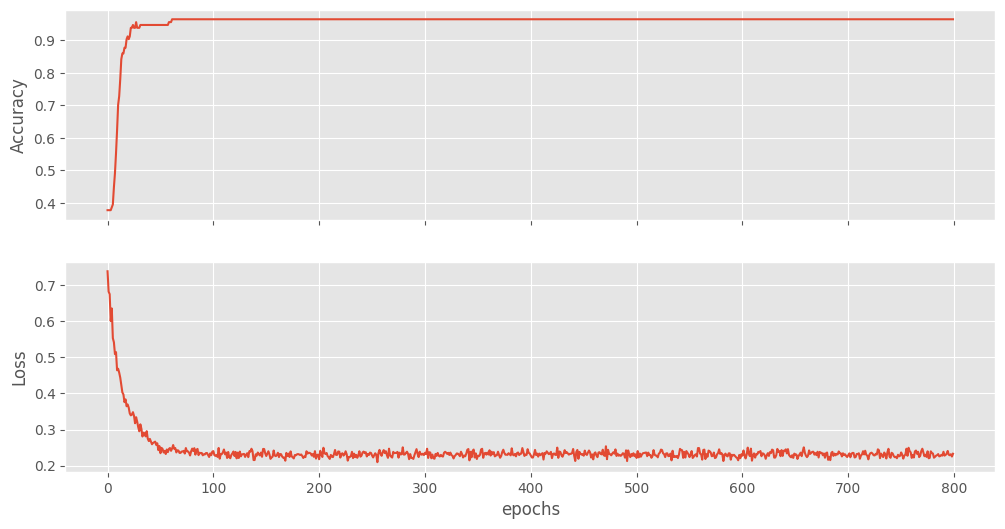

In [6]:
# Plot the Accuracy and Loss

# import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')


fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("Accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("Loss")
ax2.set_xlabel("epochs");

### 3. Convert to ZK Circuit



In [7]:
# check if notebook is in colab
try:
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

import os
import json
import ezkl

Here, we export the neural network to a `.onnx` file. EZKL reads this `.onnx` file and converts it into a circuit which then allows you to generate proofs as well as verify proofs.

In [8]:
# Specify all the files we need

model_path = os.path.join('network.onnx')
compiled_model_path = os.path.join('network.ezkl')
pk_path = os.path.join('test.pk')
vk_path = os.path.join('test.vk')
settings_path = os.path.join('settings.json')

witness_path = os.path.join('witness.json')
data_path = os.path.join('input.json')
cal_data_path = os.path.join('cal_data.json')

In [9]:
# After training, export to onnx (network.onnx) and create a data file (input.json)

# create a random input
x = test_X[0].reshape(1, 30)

# Flips the neural net into inference mode
model.eval()

# Export the model
torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  model_path,                # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

data_array = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_data = [data_array])

    # Serialize data into file:
json.dump(data, open(data_path, 'w'))





The, we  proceed to generate the settings file for EZKL and run calibrate settings to find the optimal settings for EZKL.

In [10]:
!RUST_LOG=trace
# TODO: Dictionary outputs
res = ezkl.gen_settings(model_path, settings_path)
assert res == True



In [ ]:
import json

cal_data = {'input_data': test_X.view(-1).tolist()}  # Properly prepare data
cal_data_path = 'calibration_data.json'

with open(cal_data_path, 'w') as f:
    json.dump(cal_data, f)

# Assume ezkl is imported and setup correctly
try:
    res = ezkl.calibrate_settings(cal_data_path, model_path, settings_path, "resources", max_logrows=12, scales=[2])
    print("Calibration result:", res)
except RuntimeError as e:
    print("Calibration failed with error:", e)


Next, we compile the model.

In [15]:
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

Before we can setup the circuit params, we need a SRS (Structured Reference String). The SRS is used to generate the proofs.

In [16]:
res = ezkl.get_srs( settings_path)

INFO ezkl.execute 2024-04-30 21:28:08,610 execute.rs:562 SRS does not exist, downloading...
INFO ezkl.execute 2024-04-30 21:28:19,200 execute.rs:574 Saving SRS to disk...
INFO ezkl.execute 2024-04-30 21:28:19,214 execute.rs:579 Saved SRS to disk.
INFO ezkl.execute 2024-04-30 21:28:19,214 execute.rs:581 SRS downloaded
INFO ezkl.execute 2024-04-30 21:28:19,220 execute.rs:500 read 16777476 bytes from file (vector of len = 16777476)
INFO ezkl.execute 2024-04-30 21:28:19,230 execute.rs:507 file hash: 41509f380362a8d14401c5ae92073154922fe23e45459ce6f696f58607655db7


Now we run setup, this will generate a proving key (pk) and verification key (vk). The proving key is used for proving while the verification key is used for verificaton.

In [17]:
res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
    )


assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

INFO ezkl.pfsys.srs 2024-04-30 21:28:42,745 srs.rs:23 loading srs from "/home/moyed/.ezkl/srs/kzg17.srs"
INFO ezkl.execute 2024-04-30 21:28:42,761 execute.rs:2143 downsizing params to 17 logrows
INFO ezkl.graph.model 2024-04-30 21:28:42,804 model.rs:1083 model layout...
INFO ezkl.pfsys 2024-04-30 21:28:45,851 mod.rs:501 VK took 3.88
INFO ezkl.graph.model 2024-04-30 21:28:45,857 model.rs:1083 model layout...
INFO ezkl.pfsys 2024-04-30 21:28:48,220 mod.rs:507 PK took 2.367
INFO ezkl.pfsys 2024-04-30 21:28:48,221 mod.rs:794 saving verification key 💾
INFO ezkl.pfsys 2024-04-30 21:28:48,223 mod.rs:799 done saving verification key ✅
INFO ezkl.pfsys 2024-04-30 21:28:48,224 mod.rs:776 saving proving key 💾
INFO ezkl.pfsys 2024-04-30 21:28:50,783 mod.rs:781 done saving proving key ✅


### 4. Proof Generation and Verification

Now, we can generate a proof and verify the proof as a sanity check. We will use the "evm" transcript. This will allow us to provide proofs to the EVM.

In [18]:
# Generate the Witness for the proof

# now generate the witness file
witness_path = os.path.join('witness.json')

res = ezkl.gen_witness(data_path, compiled_model_path, witness_path)
assert os.path.isfile(witness_path)

In [19]:
# Generate the proof

proof_path = os.path.join('proof.json')

proof = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        "single",
    )

print(proof)
assert os.path.isfile(proof_path)

INFO ezkl.pfsys.srs 2024-04-30 21:28:56,098 srs.rs:23 loading srs from "/home/moyed/.ezkl/srs/kzg17.srs"
INFO ezkl.execute 2024-04-30 21:28:56,116 execute.rs:2143 downsizing params to 17 logrows
INFO ezkl.pfsys 2024-04-30 21:28:56,118 mod.rs:754 loading proving key from "test.pk"
INFO ezkl.pfsys 2024-04-30 21:28:56,803 mod.rs:763 done loading proving key ✅
INFO ezkl.pfsys 2024-04-30 21:28:56,804 mod.rs:575 proof started...
INFO ezkl.graph.model 2024-04-30 21:28:56,868 model.rs:1083 model layout...
INFO ezkl.pfsys 2024-04-30 21:29:04,910 mod.rs:613 proof took 8.104


{'instances': [['7f00000000000000000000000000000000000000000000000000000000000000']], 'proof': '0x2cad6e6abcab29df586968fe35295ec48821075a374e3d70b16f6866cca53f431d541f518d4b8f3f6e7d233c47ba1b4173edc389d6dfaf8e7d0e9148510116e62ca37db5b3ff9550a066ee279506b6fcaf88bd1156861b301ea6610c1b92e4dc257163ebd9485dfa0edc592413b501c3ee2003e7ffccc08f6616e51a4503b0862a81b21fbb45e956de5633a3a9315506b8eb02a7808097aedd5a58ddab1db057135a1865242e1a0f36a210a5def7645eac31c0a8775793f798bdc8a5756dffb128685b04b9fb0b7353b7b78d27990606b5935361f76a632d2dd699c786ca5d9e07e6b143db45d96b2c1755039e5bbce52cabfd9d35f73910ba643671152257e400bc8d624146ae6da0e6507e292308d7ff80933008484e47c83b1e10115c000904129b0c538cd7a9d1faf1e1299c6b5634cfcc48daf3703cb9cd0c9c1e2603371ce3c7178f4f9ead5f8cbe320f316417b99c3f74c7922a533d815b4c9e721db20aeef5e0e47516bf0e4d8d01de69b9d402100f88d54c6897619cc4d10ef7d00f18f598da949916992b75fe7a3950121f861902ad69035584d28dc318c802ab7f2d6420b90a79bc52b468a3cfbca7904b857a42030b8060e43f1539101d137a8e066050

In [20]:
# verify our proof

res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
    )

assert res == True
print("verified")

INFO ezkl.pfsys.srs 2024-04-30 21:29:07,676 srs.rs:23 loading srs from "/home/moyed/.ezkl/srs/kzg17.srs"
INFO ezkl.execute 2024-04-30 21:29:07,692 execute.rs:2143 downsizing params to 17 logrows
INFO ezkl.pfsys 2024-04-30 21:29:07,693 mod.rs:731 loading verification key from "test.vk"
INFO ezkl.pfsys 2024-04-30 21:29:07,705 mod.rs:740 done loading verification key ✅


INFO ezkl.execute 2024-04-30 21:29:07,714 execute.rs:2101 verify took 0.7
INFO ezkl.execute 2024-04-30 21:29:07,715 execute.rs:2106 verified: true


verified


### 5. Public Verification by Ethereum Smart Contract

We can now create an EVM / .sol verifier that can be deployed on chain to verify submitted proofs using a view function.

In [21]:

abi_path = 'test.abi'
sol_code_path = 'test_1.sol'

res = ezkl.create_evm_verifier(
        vk_path,
        settings_path,
        sol_code_path,
        abi_path,
    )
assert res == True

INFO ezkl.execute 2024-04-30 21:29:09,911 execute.rs:80 checking solc installation..
INFO ezkl.pfsys.srs 2024-04-30 21:29:09,916 srs.rs:23 loading srs from "/home/moyed/.ezkl/srs/kzg17.srs"
INFO ezkl.execute 2024-04-30 21:29:09,932 execute.rs:2143 downsizing params to 17 logrows
INFO ezkl.pfsys 2024-04-30 21:29:09,934 mod.rs:731 loading verification key from "test.vk"
INFO ezkl.pfsys 2024-04-30 21:29:09,947 mod.rs:740 done loading verification key ✅


Now, we deploy Ethereum smart contract using local Anvil node running on port 3030. It confirms the successful deployment by asserting the result, then reads the contract's address from a JSON file for further use.

In [ ]:
# For running anvil and foundry locally

# curl -L https://foundry.paradigm.xyz | bash
# foundryup
# anvil -p 3030 // on seperate terminal

In [22]:
# Make sure anvil is running locally first
# run with $ anvil -p 3030
# we use the default anvil node here
import json

address_path = os.path.join("address.json")

res = ezkl.deploy_evm(
    address_path,
    sol_code_path,
    'http://127.0.0.1:3030'
)

assert res == True

with open(address_path, 'r') as file:
    addr = file.read().rstrip()

INFO ezkl.execute 2024-04-30 21:29:12,371 execute.rs:80 checking solc installation..
INFO ezkl.eth 2024-04-30 21:29:12,443 eth.rs:75 using chain 31337
INFO ezkl.execute 2024-04-30 21:29:12,641 execute.rs:1407 Contract deployed at: 0xdc64a140aa3e981100a9beca4e685f962f0cf6c9


 It uses `ezkl.verify_evm` to check the validity of a cryptographic proof stored at proof_path against the contract located at addr.

In [23]:
# make sure anvil is running locally
# $ anvil -p 3030

res = ezkl.verify_evm(
    addr,
    proof_path,
    "http://127.0.0.1:3030"
)
assert res == True

INFO ezkl.execute 2024-04-30 21:29:15,630 execute.rs:80 checking solc installation..
INFO ezkl.eth 2024-04-30 21:29:15,632 eth.rs:350 encoded: "1e8e1e1300000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000c800000000000000000000000000000000000000000000000000000000000000c202cad6e6abcab29df586968fe35295ec48821075a374e3d70b16f6866cca53f431d541f518d4b8f3f6e7d233c47ba1b4173edc389d6dfaf8e7d0e9148510116e62ca37db5b3ff9550a066ee279506b6fcaf88bd1156861b301ea6610c1b92e4dc257163ebd9485dfa0edc592413b501c3ee2003e7ffccc08f6616e51a4503b0862a81b21fbb45e956de5633a3a9315506b8eb02a7808097aedd5a58ddab1db057135a1865242e1a0f36a210a5def7645eac31c0a8775793f798bdc8a5756dffb128685b04b9fb0b7353b7b78d27990606b5935361f76a632d2dd699c786ca5d9e07e6b143db45d96b2c1755039e5bbce52cabfd9d35f73910ba643671152257e400bc8d624146ae6da0e6507e292308d7ff80933008484e47c83b1e10115c000904129b0c538cd7a9d1faf1e1299c6b5634cfcc48daf3703cb9cd0c9c1e2603371ce3c7178f4f9ead